In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split,learning_curve
from sklearn import metrics, ensemble
import matplotlib.pyplot as plt
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
cancer=pd.read_csv('Breast_Cancer.csv', sep=',')
cancer.rename(columns={"Reginol Node Positive":"Regional Node Positive"}, inplace=True)

In [3]:
cancer.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [4]:
def set_style(ax, left=True, bottom=False, axis_grid="y"):
    sns.despine(ax=ax, left=left, bottom=bottom)
    ax.grid(axis=axis_grid, linewidth=0.2, color="black")

In [5]:
colors = [
    "#8187dc", # Light purple
    "#04052e", # Black
    "#97dffc", #Light Blue
]
def count(df, x, ax, main_color=colors[0], hue=None, palette=None):
    
    sns.countplot(data=df, x=x, ax=ax, 
                  color=main_color, saturation=0.8, linewidth=3, edgecolor="black",
                  hue=hue, palette=palette)
    
    
    for container in ax.containers:
        ax.bar_label(container, 
                     color="black", fontsize=10, padding=4)
    
    ax.set_ylabel("")
    ax.set_xlabel(x, fontsize=15)
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    
    set_style(ax)

In [6]:
def hist(df, x, ax, hue=None, palette=None, main_color=colors[0], second_color=colors[1]):
    
    alpha = 0.8
    if hue:
        alpha = 0.3
    
    sns.histplot(data=df, x=x, ax=ax,
                 hue=hue, palette=palette, 
                 color=main_color, linewidth=3, bins=20, alpha=alpha,
                 kde=True, line_kws={"linewidth":1, "linestyle":"--"}
                )
    ax.lines[0].set_color(second_color)
    
    ax.set_ylabel("Number of observation")
    ax.set_xlabel(x, fontsize="x-large")
    
    set_style(ax)

In [7]:
def strip(df, x, y, ax, palette=[colors[0], colors[2]], hue=None, alpha=1):
    
    sns.stripplot(data=df, x=x, y=y, palette=palette, hue=hue, 
                  linewidth=0.5, size=4, ax=ax, alpha=alpha, edgecolor="black")
    
    ax.set_title(f"{x} vs {y}", pad=0)
    
    set_style(ax, bottom=True)

In [8]:
def cdf_plot(df, x, ax, hue=None, palette=None, main_color=colors[0]):
    
    sns.kdeplot(data=df, x=x, hue=hue, ax=ax, color=main_color,
                palette=palette,
                cumulative=True, warn_singular=False, linewidth=1, common_norm=False)
    
    set_style(ax)

In [9]:
def bar(df, x, y, ax, hue=None, palette=None, color=colors[0], order=None):
    
    sns.barplot(data=df, x=x, y=y, ax=ax, 
                hue=hue, palette=palette, color=color,
                linewidth=2, edgecolor="black", errwidth=2, capsize=0.07,
                order=order)
    
    ax.set_xlabel("")
    
    set_style(ax)

# Categorical Columns -> 11
# Numeric Columns -> 5


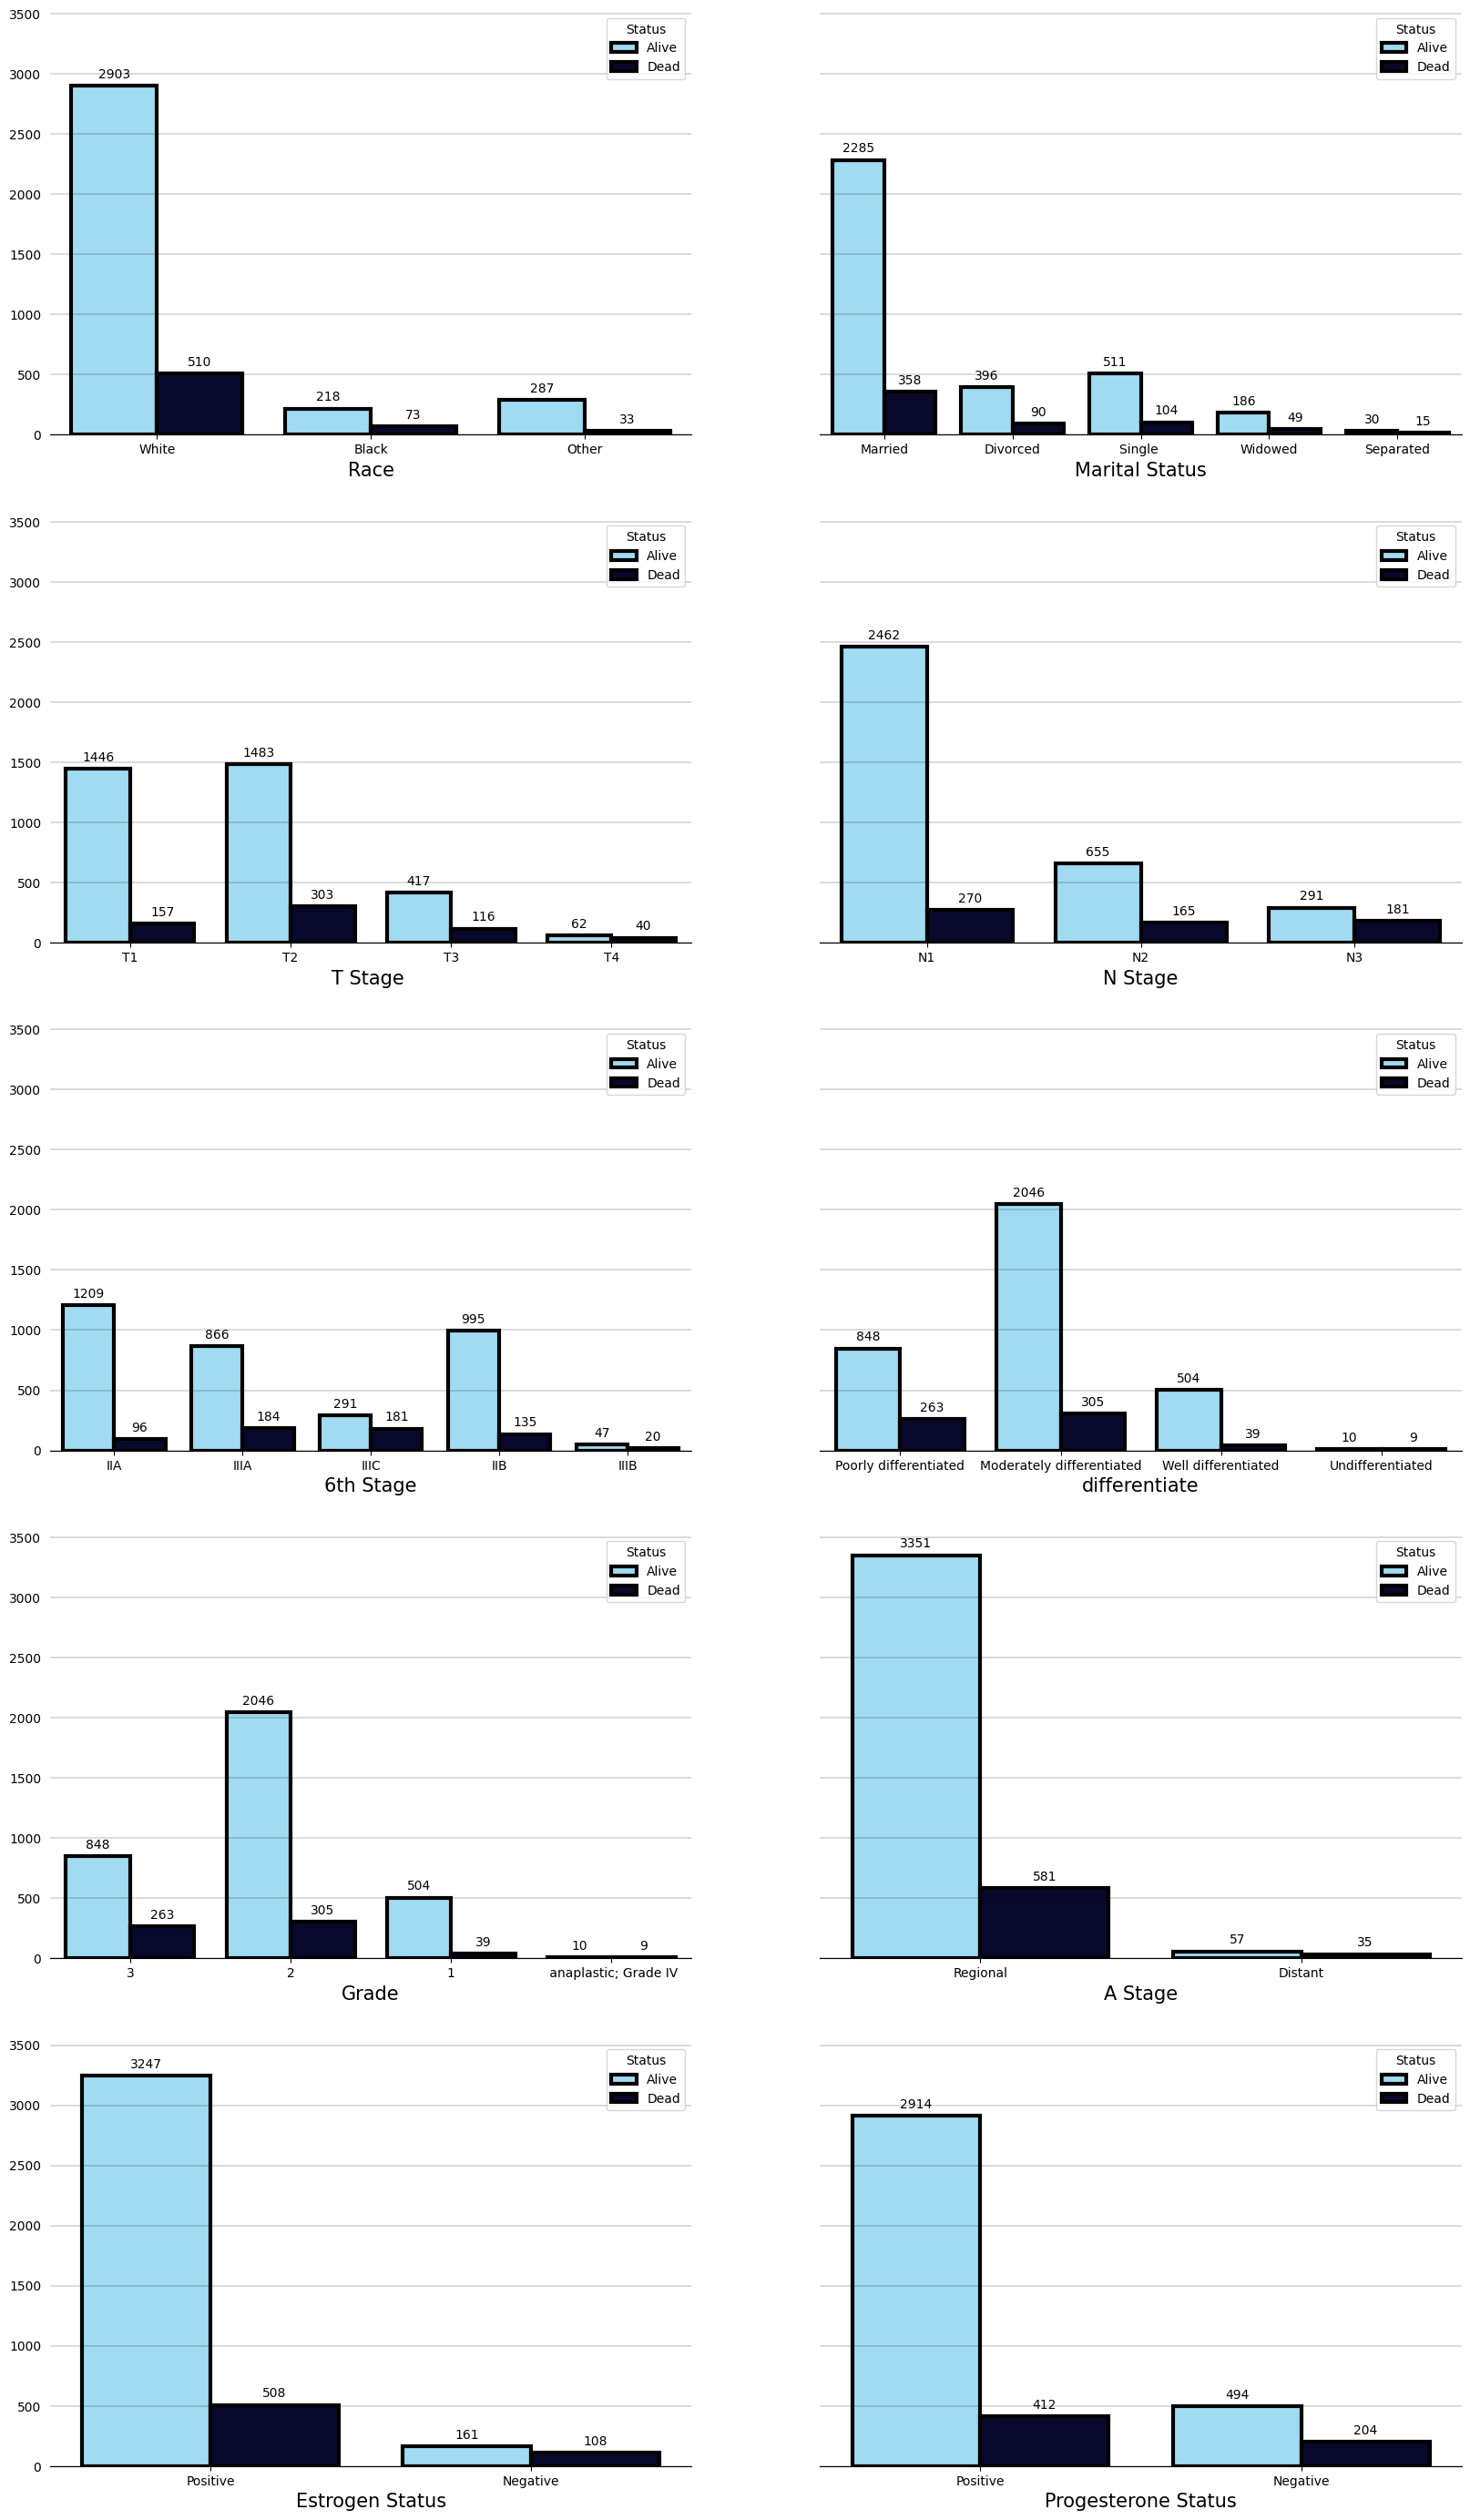

In [10]:
cat_cols = []

for col in cancer.columns:
    if cancer[col].dtype == 'object':
        cat_cols.append(col)
        
print(f"# Categorical Columns -> {len(cat_cols)}")
num_cols = []

for col in cancer.columns:
    if cancer[col].dtype == 'int64':
        num_cols.append(col)
        
print(f"# Numeric Columns -> {len(num_cols)}")
num_cols
cat_cols.remove("Status")
fig, axs = plt.subplots(5, 2, figsize=(20, 35), sharey=True)

for i, col in enumerate(cat_cols):
    ax = axs[i//2][i%2]
    
    count(cancer, col, ax, hue="Status", palette=[colors[2], colors[1]])

    
plt.show()

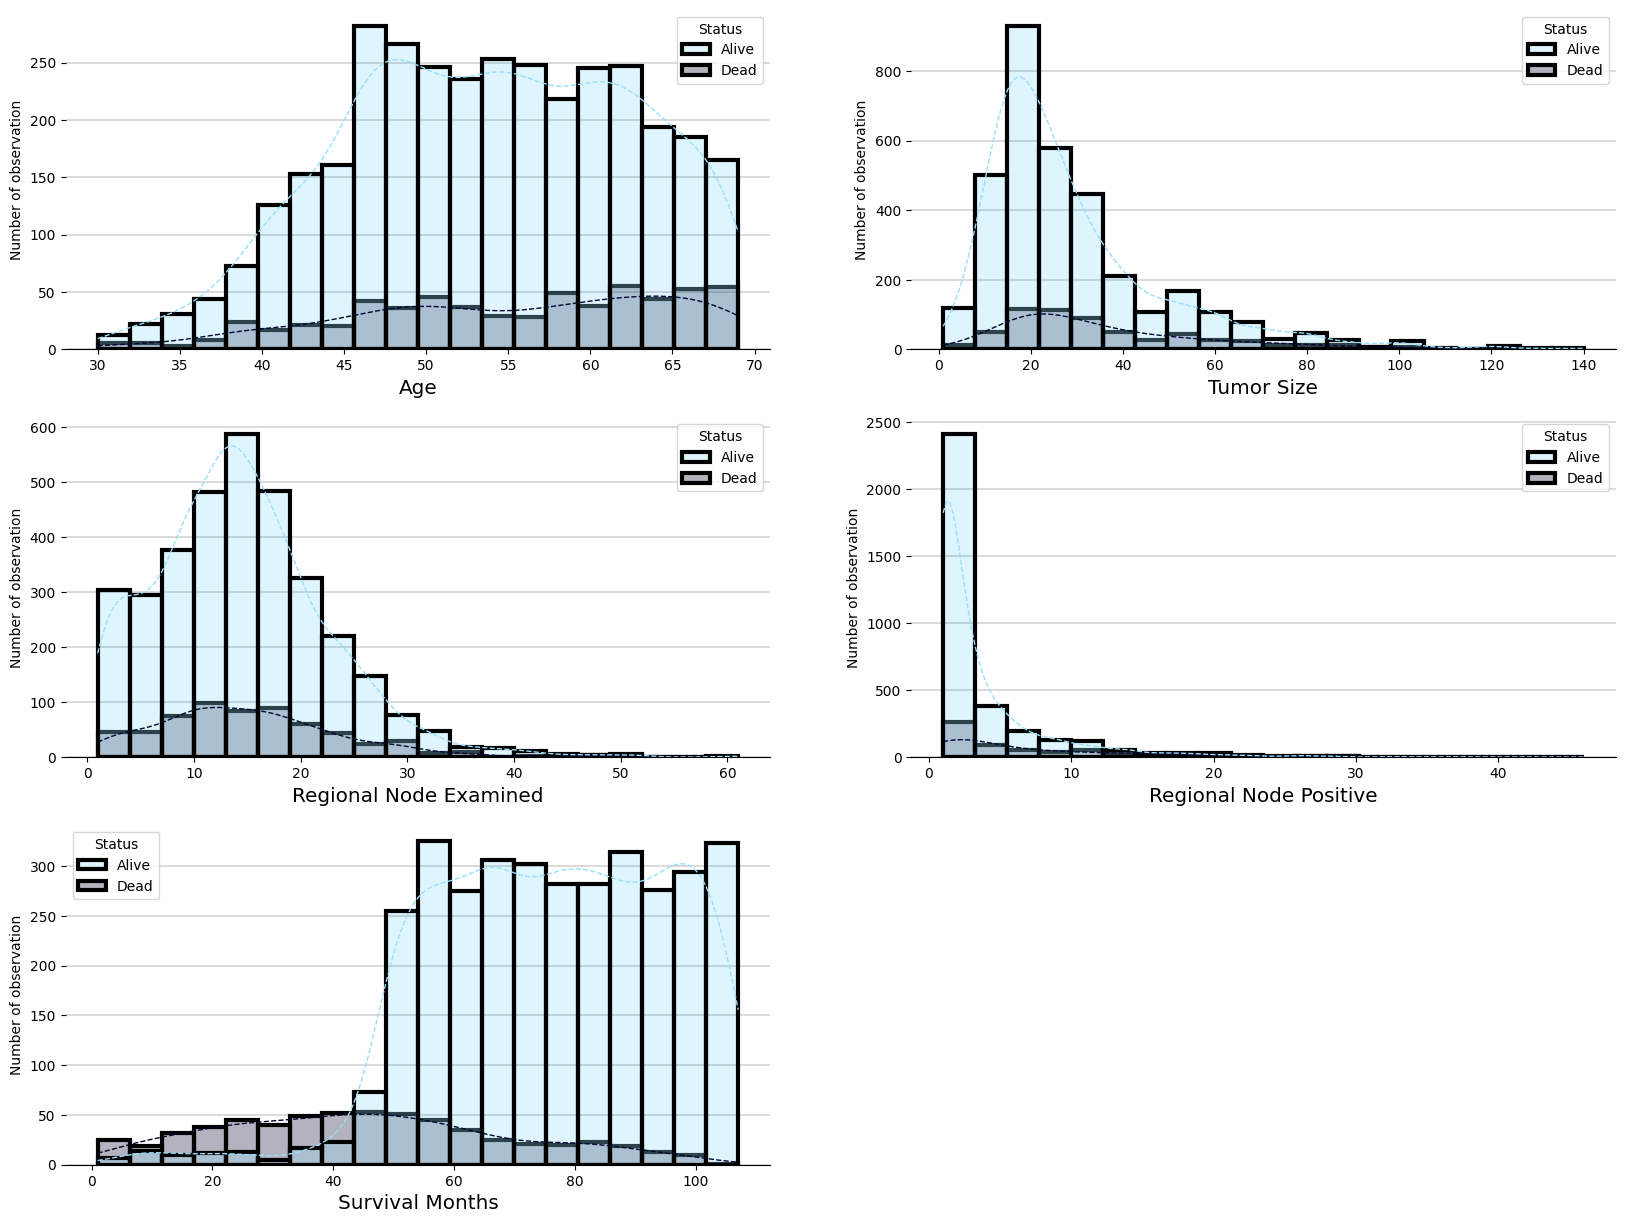

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

for i, col in enumerate(num_cols):
    ax = axs[i//2][i%2]
    
    hist(cancer, col, ax, hue="Status", palette=[colors[2], colors[1]])
    
fig.delaxes(axs[2,1])
    
plt.show()

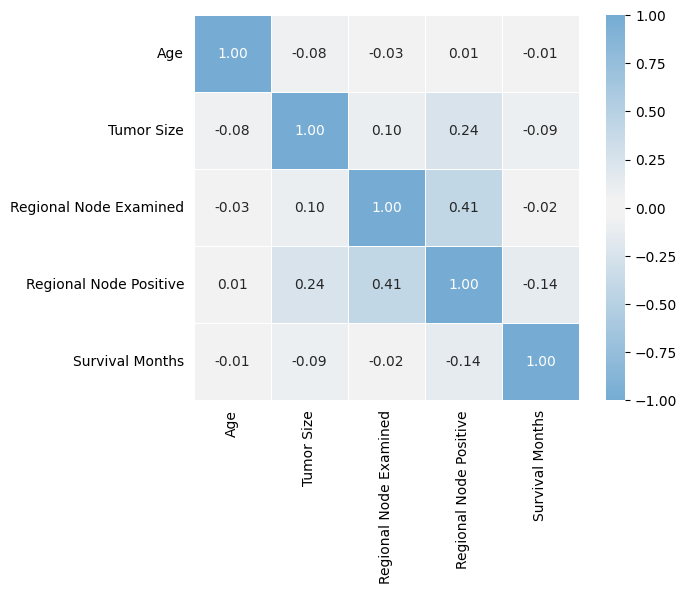

In [12]:
corr = cancer[num_cols].corr()
 
# I create my own palette to use
palette = sns.diverging_palette(236, 236, s=57, l=68, as_cmap=True, sep=15)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(corr, annot=True, ax=ax,
               cmap=palette, square=True, linewidth=.5, linecolor="white",
               vmin=-1, vmax=1, fmt=".2f")

# Changes for aesthetics
ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left=False,
    right=False
    )

plt.show()

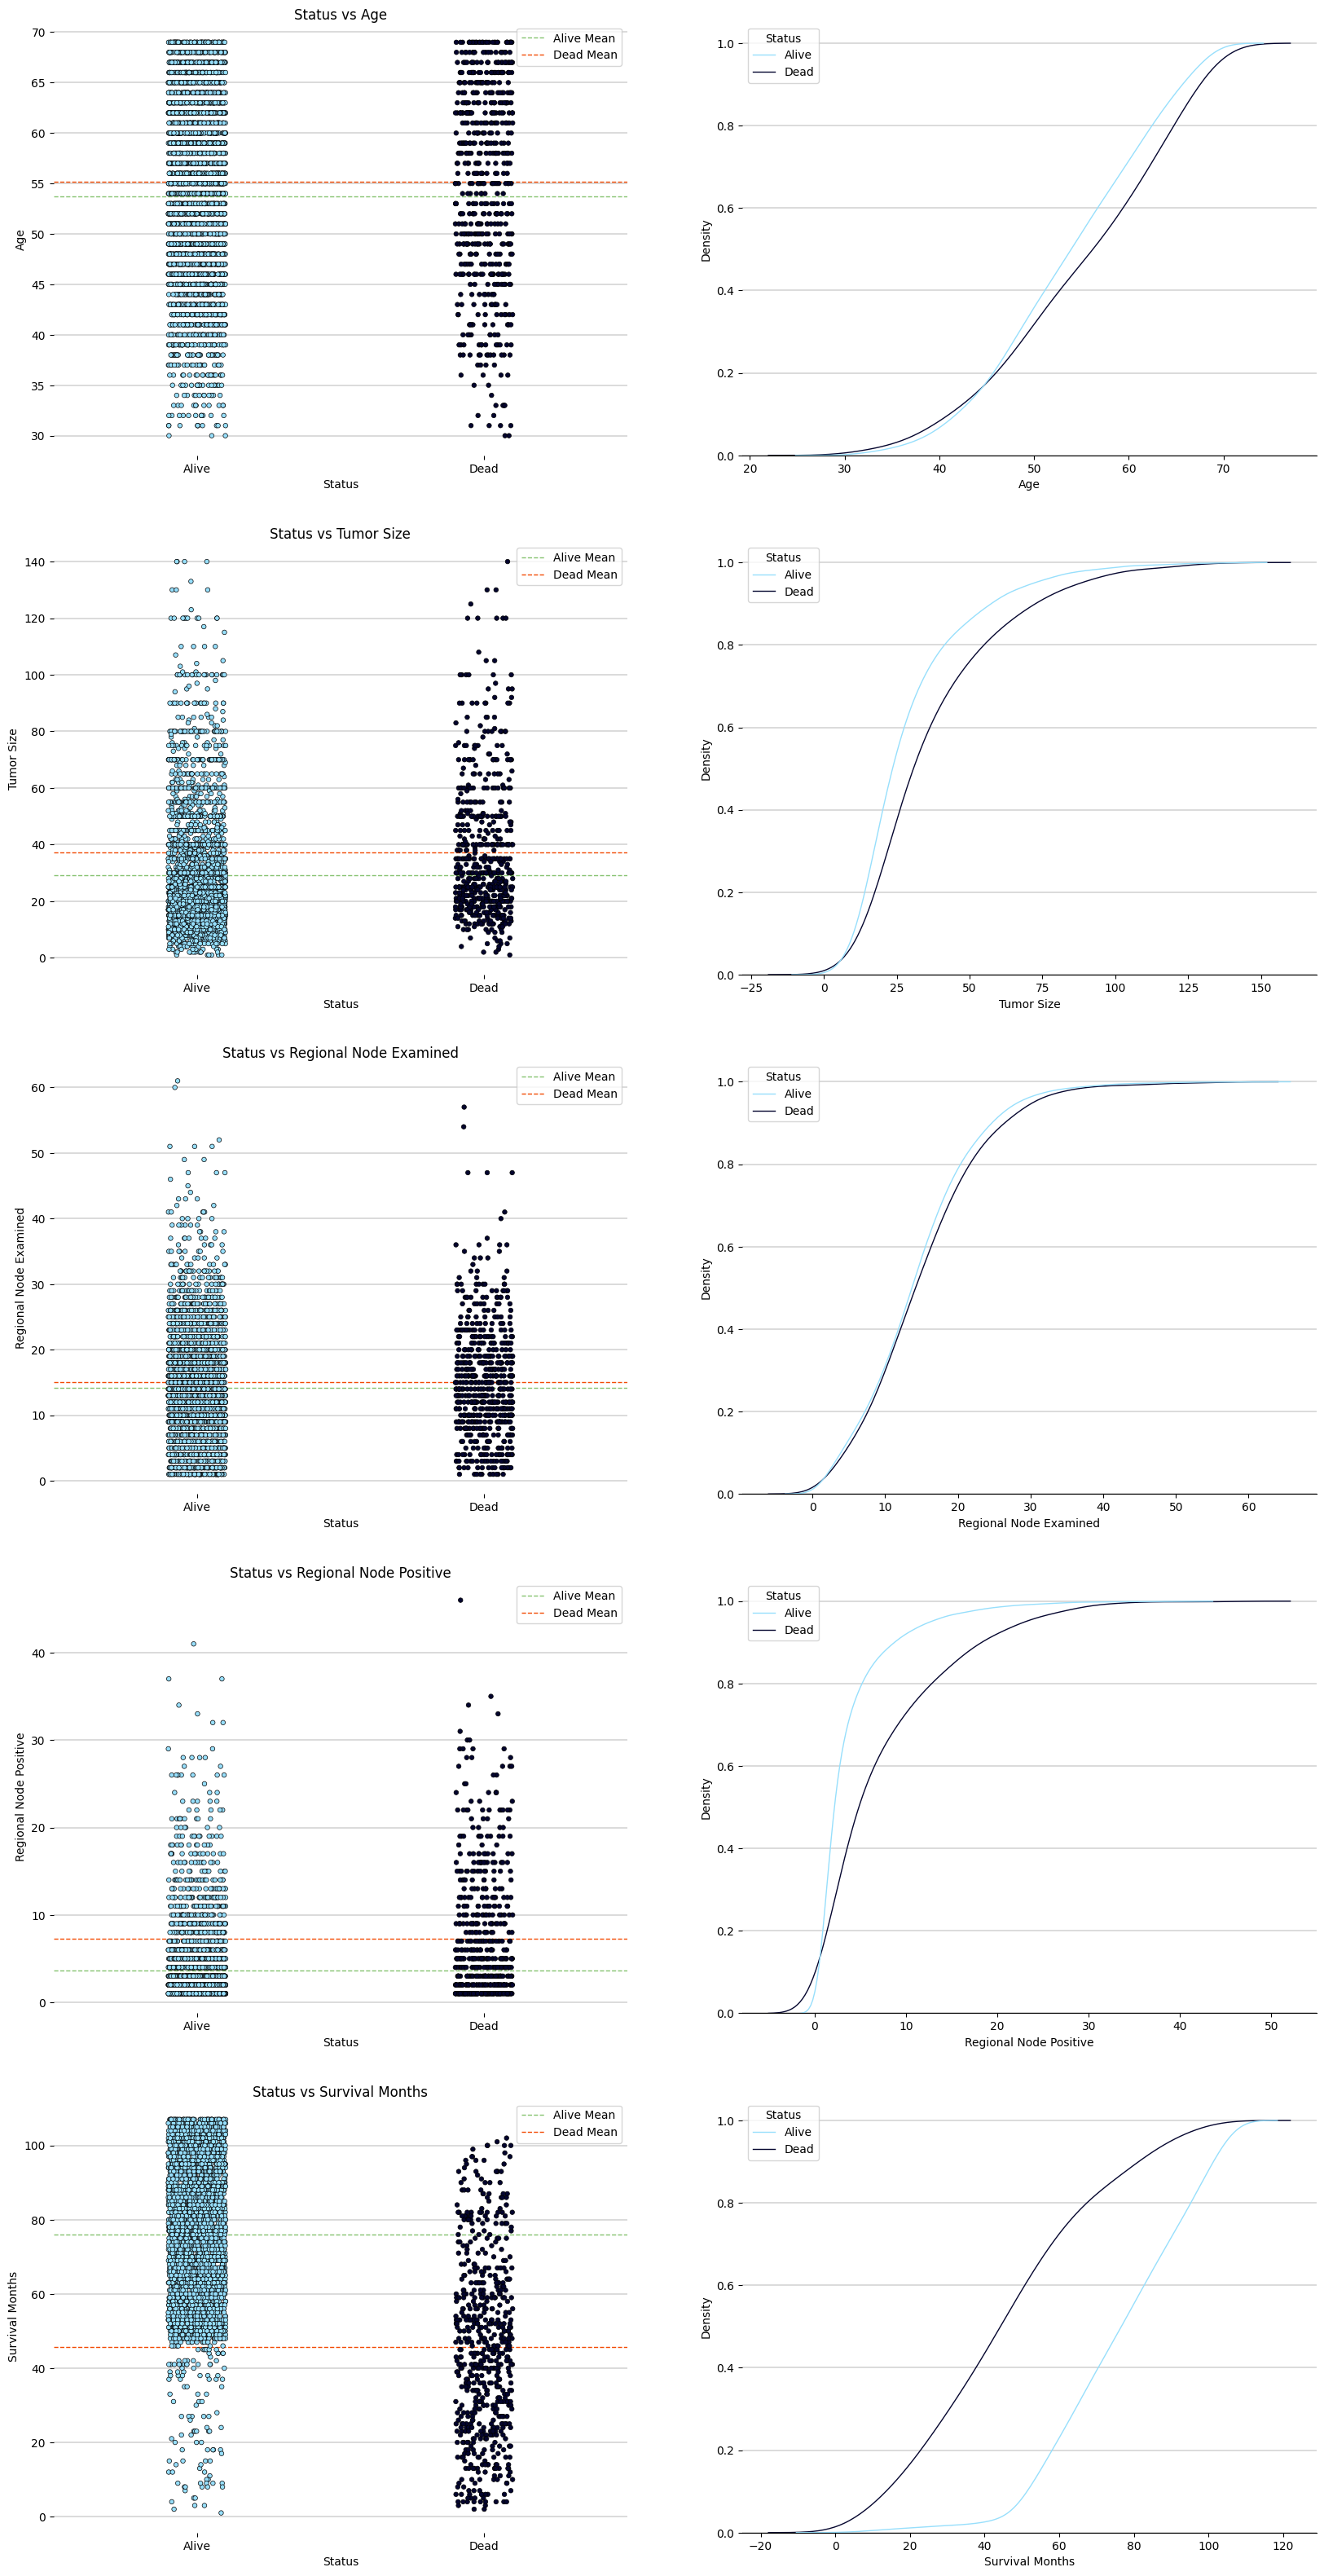

In [13]:
fig, axs = plt.subplots(5, 2, figsize=(20, 40))
i = 0
for col in num_cols:
    
    ax_left = axs[i][0]
    ax_right = axs[i][1]
    
    strip(cancer, "Status", col, ax_left, palette=[colors[2], colors[1]])
    ax_left.axhline(np.mean(cancer[cancer["Status"] == "Alive"][col]), linestyle="--", color="#85C270", linewidth=1, label="Alive Mean")
    ax_left.axhline(np.mean(cancer[cancer["Status"] == "Dead"][col]), linestyle="--", color="#f24b04", linewidth=1, label="Dead Mean")
    ax_left.legend()
    
    cdf_plot(cancer, col, ax_right, hue="Status", palette=[colors[2], colors[1]])

    i += 1
    
    
    
plt.show()

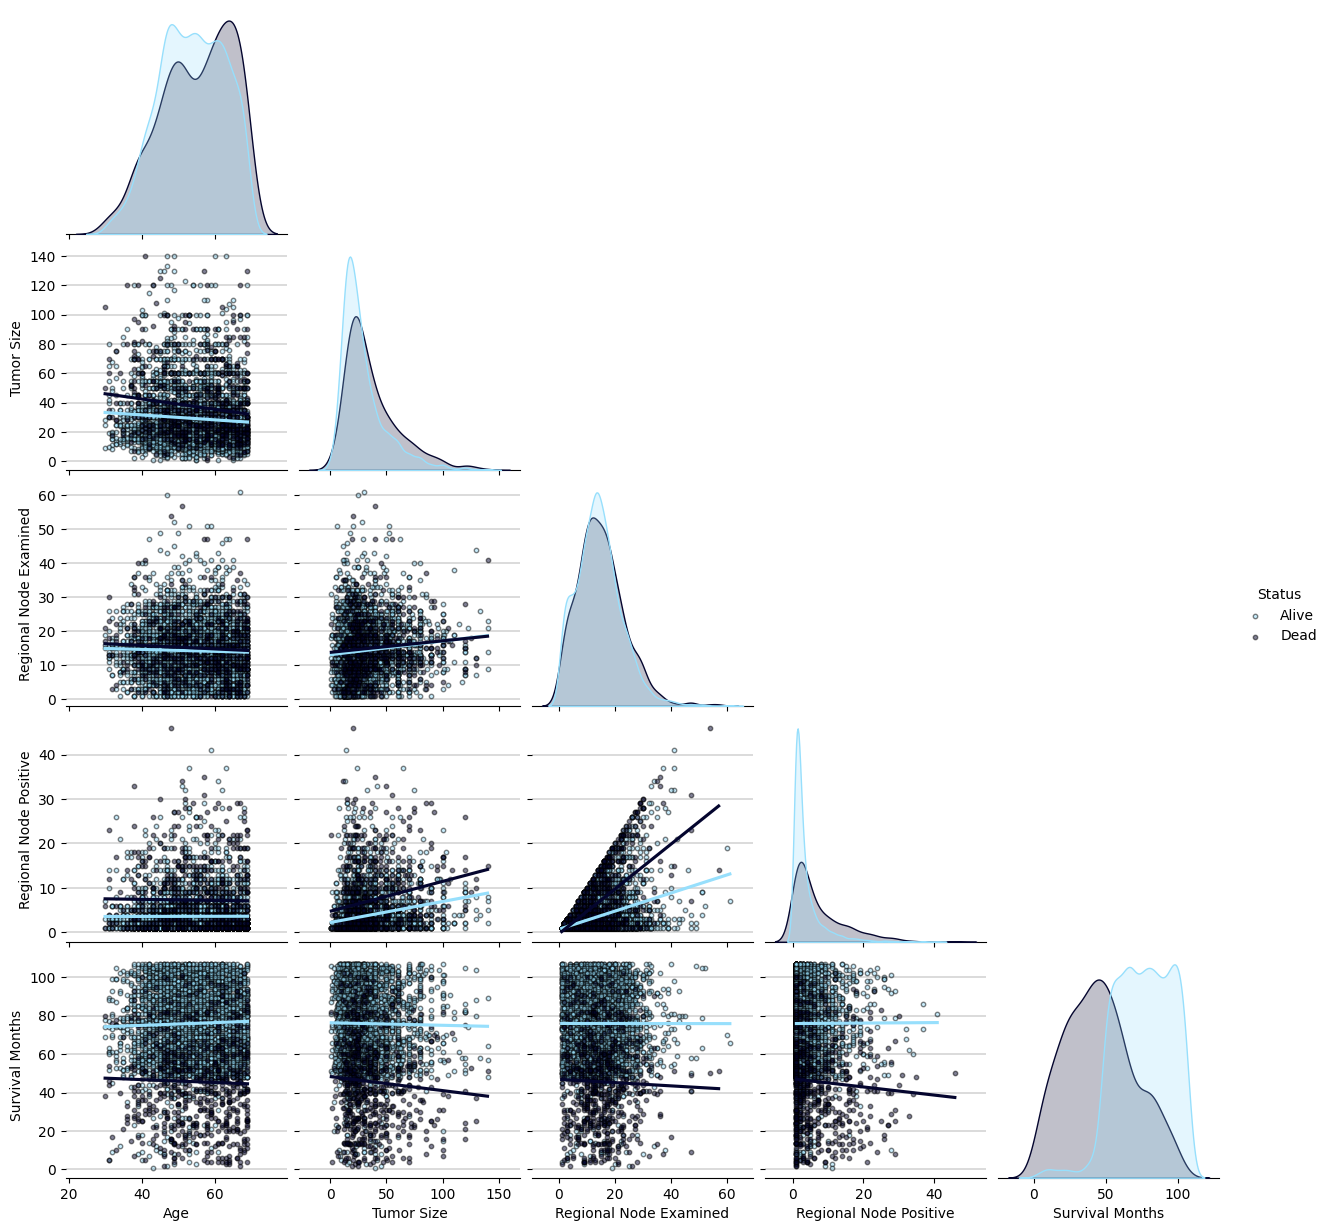

In [14]:
g = sns.pairplot(cancer, hue="Status", palette=[colors[2], colors[1]], corner=True,
            kind="reg", 
            plot_kws={
                "ci":None,
                "scatter_kws": {
                    "alpha":0.5, "s":10, "edgecolor":"black"
                }},
            diag_kws={
                "common_norm":False
            })

for axs in g.axes:
    for ax in axs:
        if ax:
            set_style(ax)

plt.show()

In [15]:
cancercopy = cancer.drop("Race", axis=1) 
cancercopy=cancercopy.replace( ['Married' ,'Divorced', 'Single ', 'Widowed', 'Separated','T1', 'T2', 'T3', 'T4','N1', 'N2', 'N3','IIA', 'IIIA', 'IIIC', 'IIB', 'IIIB','Poorly differentiated', 'Moderately differentiated', 'Well differentiated', 
 'Undifferentiated','3' ,'2', '1', ' anaplastic; Grade IV','Regional', 'Distant','Positive' ,'Negative'],[1,2,3,4,5,1,2,3,4,1,2,3,1,2,3,4,5,1,2,3,4,3,2,1,4,1,2,1,0]) 
X = cancercopy.drop(columns=["Status"]) 
y = cancer["Status"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


In [16]:
print(len(X_train.columns))
print(len(X_test.columns))
acc_ = []
train_acc = []
test_acc = []

14
14


In [17]:
#AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier()
model_ada.fit(X_train, y_train)

y_pred_train = model_ada.predict(X_train)

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index = model_ada.classes_, columns = model_ada.classes_)
print(conf_mat)


print("Accuracy on train:", metrics.accuracy_score(y_train, y_pred_train))

       Alive  Dead
Alive   2111    61
Dead     185   218
Accuracy on train: 0.9044660194174757


In [19]:
score=cross_val_score(model_ada,X_train,y_train,scoring='accuracy',cv=5)

acc_.append(statistics.mean(score))

print('CV-accuracy: ',statistics.mean(score))

CV-accuracy:  0.897864077669903


In [20]:
#GradientBoosting

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

train_acc = []
test_acc = []

model_gb = GradientBoostingClassifier(random_state = 42,
                                   n_estimators = 100,
                                   max_depth = 3,
                                   learning_rate = 0.1

)

y_train.replace(['Alive', 'Dead'], [0, 1], inplace=True)
y_test.replace(['Alive', 'Dead'], [0, 1], inplace=True)

model_gb.fit(X_train, y_train)

y_pred_train = model_gb.predict(X_train)

predictions = [round(value) for value in y_pred_train]
print(classification_report(y_train, predictions))

accuracy = accuracy_score(y_train, predictions)
train_acc.append(accuracy)

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index = model_gb.classes_, columns = model_gb.classes_)
print(conf_mat)

print("Accuracy on train:", metrics.accuracy_score(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2172
           1       0.91      0.61      0.73       403

    accuracy                           0.93      2575
   macro avg       0.92      0.80      0.85      2575
weighted avg       0.93      0.93      0.92      2575

      0    1
0  2149   23
1   156  247
Accuracy on train: 0.9304854368932038


In [22]:
score=cross_val_score(model_gb,X_train,y_train,scoring='accuracy',cv=5)

acc_.append(statistics.mean(score))

print('CV-accuracy: ',statistics.mean(score))

CV-accuracy:  0.9040776699029126


In [23]:
acc_df = pd.DataFrame(list(zip(train_acc, acc_)),
               columns =['Train accuracy', 'CV-accuracy'])
acc_df.index = ['GradientBoosting']
acc_df.transpose()

,GradientBoosting
Train accuracy,0.930485
CV-accuracy,0.897864


In [24]:
#XGBoost

In [25]:
train_acc = []
test_acc = []

model_xgb = xgb.XGBClassifier(seed = 42,
                          n_estimators = 100,
                          max_depth = 3,
                          learning_rate = 0.1)
model_xgb.fit(X_train, y_train)

y_pred_train = model_xgb.predict(X_train)

predictions = [round(value) for value in y_pred_train]
print(classification_report(y_train, predictions))

accuracy = accuracy_score(y_train, predictions)
train_acc.append(accuracy)

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index = model_xgb.classes_, columns = model_xgb.classes_)
print(conf_mat)

print("Accuracy on train:", metrics.accuracy_score(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2172
           1       0.89      0.57      0.69       403

    accuracy                           0.92      2575
   macro avg       0.91      0.78      0.82      2575
weighted avg       0.92      0.92      0.91      2575

      0    1
0  2143   29
1   175  228
Accuracy on train: 0.9207766990291262


In [26]:
score=cross_val_score(model_xgb,X_train,y_train,scoring='accuracy',cv=5)

acc_.append(statistics.mean(score))

print('CV-accuracy: ', statistics.mean(score))

CV-accuracy:  0.9040776699029126


In [27]:
acc_df = pd.DataFrame(list(zip(train_acc, acc_)),
               columns =['Train accuracy', 'CV-accuracy'])
acc_df.index = ['XGBoost']
acc_df.transpose()

,XGBoost
Train accuracy,0.920777
CV-accuracy,0.897864


In [28]:
grid_param = {
              'n_estimators':  [50, 100, 300, 500, 1000],
              'max_depth': [3, 4, 6],
              'learning_rate': [0.01, 0.05, 0.1, 0.3],
              'lambda': [0.5, 1, 5, 10]
}

In [29]:
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=100, max_depth=3,
                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=42), 
                        param_grid = grid_param, scoring='accuracy',n_jobs=4, cv=5)

gsearch.fit(X_train,y_train)
gsearch.best_params_

{'lambda': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}

In [30]:
train_acc = []
test_acc = []

best_param = {
              'n_estimators':  50,
              'max_depth': 4,
              'learning_rate': 0.01,
              'lambda': 5
}

model_xgb = xgb.XGBClassifier(seed = 42, param_grid = grid_param)

model_xgb.fit(X_train, y_train)

y_pred_train = model_xgb.predict(X_train)

predictions = [round(value) for value in y_pred_train]
print(classification_report(y_train, predictions))

accuracy = accuracy_score(y_train, predictions)
train_acc.append(accuracy)

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index = model_xgb.classes_, columns = model_xgb.classes_)
print(conf_mat)

print("Accuracy on train:", metrics.accuracy_score(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2172
           1       1.00      0.98      0.99       403

    accuracy                           1.00      2575
   macro avg       1.00      0.99      0.99      2575
weighted avg       1.00      1.00      1.00      2575

      0    1
0  2172    0
1     9  394
Accuracy on train: 0.996504854368932


In [31]:
score=cross_val_score(model_xgb,X_train,y_train,scoring='accuracy',cv=5)

acc_.append(statistics.mean(score))

print('CV-accuracy: ', statistics.mean(score))

CV-accuracy:  0.8877669902912622


In [32]:
acc_df = pd.DataFrame(list(zip(train_acc, acc_)),
               columns =['Train accuracy', 'CV-accuracy'])
acc_df.index = ['XGBoost best params']
acc_df.transpose()

,XGBoost best params
Train accuracy,0.996505
CV-accuracy,0.897864


In [33]:
acc_df = pd.DataFrame(acc_,
               columns =['Accuracy'])
acc_df.index = ['AdaBoost', 'GradientBoostingClassifier', 'XGBoost', 'XGBoostBestParams']
acc_df.transpose()

,AdaBoost,GradientBoostingClassifier,XGBoost,XGBoostBestParams
Accuracy,0.897864,0.904078,0.904078,0.887767


In [34]:
y_pred_test = model_gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
test_acc.append(accuracy)


print("Accuracy on test for GradientBoosting:", metrics.accuracy_score(y_test, y_pred_test))

Accuracy on test for GradientBoosting: 0.9167701863354037
